# Gaussian Blur with Cuda Bindings

## 1. The 2D Gaussian Function

The Gaussian function (bell curve) in 2D is defined as:

$$G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$$

Where:
- $x, y$ are the coordinates relative to the center of the kernel
- $\sigma$ (sigma) is the standard deviation, controlling the spread/width
- $e$ is Euler's number ($\approx 2.71828$)

## 2. Standard Deviation ($\sigma$) Effect

The parameter $\sigma$ controls the blur strength:

- **Small $\sigma$ (0.5-1.0)**: Narrow bell curve → subtle blur
- **Large $\sigma$ (3.0-5.0)**: Wide bell curve → strong blur

The variance is $\sigma^2$, and roughly 95% of the weight is within $2\sigma$ from the center.

## 3. Creating a Discrete Kernel

For a kernel of size $n \times n$ (e.g., $5 \times 5$), we:

1. Create a grid of coordinates centered at $(0, 0)$:
   $$\text{For } n=5: \quad x, y \in \{-2, -1, 0, 1, 2\}$$

2. Evaluate $G(x, y)$ at each grid point:
   $$K[i][j] = G(x_i, y_j) = \frac{1}{2\pi\sigma^2} e^{-\frac{x_i^2 + y_j^2}{2\sigma^2}}$$

3. Normalize so the sum equals 1:
   $$K_{\text{normalized}}[i][j] = \frac{K[i][j]}{\sum_{m,n} K[m][n]}$$

In [29]:
from cuda.bindings import driver, nvrtc
import numpy as np
from PIL import Image
from PIL import ImageDraw


def checkCudaErrors(result):
    if result[0].value:
        raise RuntimeError(f"CUDA error {result[0]}")
    return result[1] if len(result) == 2 else (result[1:]) if len(result) > 2 else None


def generate_gaussian_kernel_code(kernel_size, sigma):
    # Create Gaussian kernel
    ax = np.arange(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))

    # Scale to integers for better precision in GPU
    scale_factor = 1000
    kernel_int = np.round(kernel * scale_factor).astype(int)
    print(f"Kernel: {kernel_int}")
    kernel_sum = kernel_int.sum()
    print(f"Kernel Sum: {kernel_sum}")

    # Generate kernel array as C++ string
    kernel_str = "{\n"
    for row in kernel_int:
        kernel_str += "        {" + ", ".join(map(str, row)) + "},\n"
    kernel_str += "    }"

    # Generate CUDA code
    offset = kernel_size // 2

    code = f"""
extern "C" __global__
void gaussian_blur(const unsigned char* input, 
                   unsigned char* output,
                   int width, int height, int channels)
{{
    // Calculate 2D pixel position
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    
    if (x >= width || y >= height) return;
    
    // {kernel_size}x{kernel_size} Gaussian kernel (sigma={sigma})
    const float kernel[{kernel_size}][{kernel_size}] = {kernel_str};
    const float kernel_sum = {kernel_sum}.0f;
    
    // Process each channel (grayscale=1, RGB=3, RGBA=4)
    for (int c = 0; c < channels; c++) {{
        float sum = 0.0f;
        
        // Apply convolution: weighted sum of neighbors
        for (int ky = 0; ky < {kernel_size}; ky++) {{
            for (int kx = 0; kx < {kernel_size}; kx++) {{
                // Calculate neighbor position
                int nx = x + kx - {offset};
                int ny = y + ky - {offset};
                
                // Clamp to image edges
                nx = max(0, min(nx, width - 1));
                ny = max(0, min(ny, height - 1));
                
                // Accumulate weighted pixel value
                int idx = (ny * width + nx) * channels + c;
                sum += input[idx] * kernel[ky][kx];
            }}
        }}
        
        // Write normalized result
        int out_idx = (y * width + x) * channels + c;
        output[out_idx] = (unsigned char)(sum / kernel_sum);
    }}
}}
"""
    return code


generate_gaussian_kernel_code(7, 1.5)

Kernel: [[  18   56  108  135  108   56   18]
 [  56  169  329  411  329  169   56]
 [ 108  329  641  801  641  329  108]
 [ 135  411  801 1000  801  411  135]
 [ 108  329  641  801  641  329  108]
 [  56  169  329  411  329  169   56]
 [  18   56  108  135  108   56   18]]
Kernel Sum: 13644


'\nextern "C" __global__\nvoid gaussian_blur(const unsigned char* input, \n                   unsigned char* output,\n                   int width, int height, int channels)\n{\n    // Calculate 2D pixel position\n    int x = blockIdx.x * blockDim.x + threadIdx.x;\n    int y = blockIdx.y * blockDim.y + threadIdx.y;\n\n    if (x >= width || y >= height) return;\n\n    // 7x7 Gaussian kernel (sigma=1.5)\n    const float kernel[7][7] = {\n        {18, 56, 108, 135, 108, 56, 18},\n        {56, 169, 329, 411, 329, 169, 56},\n        {108, 329, 641, 801, 641, 329, 108},\n        {135, 411, 801, 1000, 801, 411, 135},\n        {108, 329, 641, 801, 641, 329, 108},\n        {56, 169, 329, 411, 329, 169, 56},\n        {18, 56, 108, 135, 108, 56, 18},\n    };\n    const float kernel_sum = 13644.0f;\n\n    // Process each channel (grayscale=1, RGB=3, RGBA=4)\n    for (int c = 0; c < channels; c++) {\n        float sum = 0.0f;\n\n        // Apply convolution: weighted sum of neighbors\n        for (

## Generated String

After running the code block above your string should look like this C++ code

```c++
extern "C" __global__
void gaussian_blur(const unsigned char* input, 
                   unsigned char* output,
                   int width, int height, int channels)
{
    // Calculate 2D pixel position
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    // 7x7 Gaussian kernel (sigma=1.5)
    const float kernel[7][7] = {
        {18, 56, 108, 135, 108, 56, 18},
        {56, 169, 329, 411, 329, 169, 56},
        {108, 329, 641, 801, 641, 329, 108},
        {135, 411, 801, 1000, 801, 411, 135},
        {108, 329, 641, 801, 641, 329, 108},
        {56, 169, 329, 411, 329, 169, 56},
        {18, 56, 108, 135, 108, 56, 18},
    };
    const float kernel_sum = 13644.0f;

    // Process each channel (grayscale=1, RGB=3, RGBA=4)
    for (int c = 0; c < channels; c++) {
        float sum = 0.0f;

        // Apply convolution: weighted sum of neighbors
        for (int ky = 0; ky < 7; ky++) {
            for (int kx = 0; kx < 7; kx++) {
                // Calculate neighbor position
                int nx = x + kx - 3;
                int ny = y + ky - 3;

                // Clamp to image edges
                nx = max(0, min(nx, width - 1));
                ny = max(0, min(ny, height - 1));

                // Accumulate weighted pixel value
                int idx = (ny * width + nx) * channels + c;
                sum += input[idx] * kernel[ky][kx];
            }
        }

        // Write normalized result
        int out_idx = (y * width + x) * channels + c;
        output[out_idx] = (unsigned char)(sum / kernel_sum);
    }
}
```

## Explaining the Code

```c++
int x = blockIdx.x * blockDim.x + threadIdx.x;
int y = blockIdx.y * blockDim.y + threadIdx.y;
```

GPUs group cores into streaming multiprocessors. For my GPU (5090 RTX) the blocks look like

```ascii
NVIDIA RTX 5090 (Blackwell - GB202)
════════════════════════════════════════════════════════════════════════════

┌──────────────────────────────────────────────────────────────────────────┐
│                         170 Streaming Multiprocessors                    │
│                         21,760 CUDA Cores Total                          │
└──────────────────────────────────────────────────────────────────────────┘

 SM0   SM1   SM2   SM3   SM4   SM5   SM6   SM7   SM8   SM9   SM10  SM11
┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐
│128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│
└───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘
                                ...
                      (146 more SMs in middle)
                                ...
SM158 SM159 SM160 SM161 SM162 SM163 SM164 SM165 SM166 SM167 SM168 SM169
┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐ ┌───┐
│128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│ │128│
└───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘ └───┘

Each SM: 128 CUDA cores + 4 Tensor Cores + 1 RT Core
────────────────────────────────────────────────────────────────────────────
```

x and y are computing the following

```python
x = (which block) × (block size) + (position in block)
y = (which block) × (block size) + (position in block)
```

### Threading per Pixel

Another way to view this is that each thread computes the blur for one pixel. Let's look at this example

```ascii
800×600 IMAGE DIVIDED FOR GPU
═══════════════════════════════════════════════════════════════

STEP 1: Choose Block Size
──────────────────────────
BLOCK_SIZE_X = 16 threads
BLOCK_SIZE_Y = 16 threads
Each block = 16×16 = 256 threads (256 pixels)


STEP 2: Calculate Grid Size
────────────────────────────
GRID_SIZE_X = 800 ÷ 16 = 50 blocks wide
GRID_SIZE_Y = 600 ÷ 16 = 38 blocks tall
Total = 50 × 38 = 1,900 blocks


STEP 3: Image Divided into Grid of Blocks
──────────────────────────────────────────

         50 blocks wide →
    ┌───┬───┬───┬───┬───┬───┬───┐
    │0,0│1,0│2,0│3,0│4,0│...│49,0│  ← Row 0 (38 rows total)
    ├───┼───┼───┼───┼───┼───┼───┤
38  │0,1│1,1│2,1│3,1│4,1│...│49,1│  ← Row 1
    ├───┼───┼───┼───┼───┼───┼───┤  ↓
b   │0,2│1,2│2,2│3,2│4,2│...│49,2│
l   ├───┼───┼───┼───┼───┼───┼───┤
o   │ ⋮ │ ⋮ │ ⋮ │ ⋮ │ ⋮ │ ⋮ │ ⋮ │
c   ├───┼───┼───┼───┼───┼───┼───┤
k   │0,37│1,37│...│     │   │49,37│ ← Row 37
s   └───┴───┴───┴───┴───┴───┴───┘


STEP 4: Each Block Contains 16×16 Threads
──────────────────────────────────────────

Zoom into Block(5,3):
                         16 threads wide →
    ┌──┬──┬──┬──┬──┬──┬──┬──┬──┬──┬──┬──┬──┬──┬──┬──┐
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ ← Row 0
    ├──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┤
16  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    ├──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┤  ↓
t   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
h   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
r   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
e   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
a   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
d   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
s   │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    │  │  │  │  │  │  │  │🔲│ │  │  │  │  │  │  │  │ ← Row 12
    │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │
    └──┴──┴──┴──┴──┴──┴──┴──┴──┴──┴──┴──┴──┴──┴──┴──┘
                           ↑
                      Thread(7,12)
                      
Each cell = 1 thread = 1 pixel


STEP 5: Thread Calculates Its Pixel
────────────────────────────────────

Thread(7,12) in Block(5,3):

x = blockIdx.x × blockDim.x + threadIdx.x
  = 5 × 16 + 7 = 87 (column)

y = blockIdx.y × blockDim.y + threadIdx.y
  = 3 × 16 + 12 = 60 (row)

This thread processes pixel (87, 60) ✓


SUMMARY
═══════════════════════════════════════════════════════════════
Image:     800 × 600 = 480,000 pixels
Grid:      50 × 38 = 1,900 blocks
Block:     16 × 16 = 256 threads
Total:     1,900 × 256 = 486,400 threads
```

### Summary

X and Y are calculating the column and row for the thread process

**`x` = Which pixel COLUMN this thread processes**

**`y` = Which pixel ROW this thread processes**


## Explaining the Convolutions

```c
int nx = x + kx - 3;
int ny = y + ky - 3;
```
this centers the kernel

Example: If current pixel is at (100, 100):

When kx=0, ky=0 → neighbor at (97, 97) — top-left of kernel
When kx=3, ky=3 → neighbor at (100, 100) — center (current pixel)
When kx=6, ky=6 → neighbor at (103, 103) — bottom-right of kernel

The -3 offset centers the kernel (since kernel_size // 2 = 7 // 2 = 3)

```c
nx = max(0, min(nx, width - 1));
ny = max(0, min(ny, height - 1));
```

Handles edge cases of negative positions


```c
int idx = (ny * width + nx) * channels + c;
```

converts 2D image coordinates + channel into a 1D array index\

```c
// Write normalized result
int out_idx = (y * width + x) * channels + c;
output[out_idx] = (unsigned char)(sum / kernel_sum);
```

calculates where to write the blurred pixel for the output array
This will normalize the values back to 0-255


```c
// 7x7 Gaussian kernel (sigma=1.5)
const float kernel[7][7] = {
    {18, 56, 108, 135, 108, 56, 18},
    {56, 169, 329, 411, 329, 169, 56},
    {108, 329, 641, 801, 641, 329, 108},
    {135, 411, 801, 1000, 801, 411, 135},
    {108, 329, 641, 801, 641, 329, 108},
    {56, 169, 329, 411, 329, 169, 56},
    {18, 56, 108, 135, 108, 56, 18},
};
const float kernel_sum = 13644.0f;
```

The reason that these are integer looking floats (These are floats without the fraction) is so the scaling of the numbers work out to be easier to read and process. Small floats overtime will lose precision.

## Performing the Gaussian Blur

## Input Processing

**Purpose:** Normalize image format

- Converts grayscale images from 2D to 3D by adding channel dimension
- Extracts image dimensions: height, width, and number of channels
- Ensures consistent 3D array format for both grayscale and color images

---

## Step 1: Initialize CUDA

**Purpose:** Set up GPU access

- Initializes the CUDA driver API (required before any GPU operations)
- Gets a handle to the first GPU device in the system
- Queries device information: name and compute capability
- Compute capability determines which GPU architecture to compile for

---

## Step 2: Compile CUDA Kernel

**Purpose:** Convert CUDA C++ code to executable format

- Generates CUDA C++ source code string with Gaussian kernel weights
- Creates an NVRTC program object from the source code
- Compiles the program to PTX (intermediate assembly-like code)
- Extracts the compiled PTX for loading onto the GPU
- Uses architecture flag to optimize for specific GPU generation

---

## Step 3: Load Module

**Purpose:** Load compiled code onto GPU

- Creates a CUDA context (like a process for GPU operations)
- Loads PTX code into a module on the GPU
- GPU driver converts PTX to actual machine code
- Gets a function handle to the kernel by name for later launching

---

## Step 4: Allocate GPU Memory

**Purpose:** Reserve space on GPU for images

- Calculates buffer size: width × height × channels bytes
- Allocates two memory blocks on GPU:
  - Input buffer for original image
  - Output buffer for blurred result
- Returns device pointers (GPU memory addresses)

---

## Step 5: Transfer Data to GPU

**Purpose:** Copy image from CPU to GPU

- Creates a CUDA stream for asynchronous operations
- Copies image data from CPU memory to GPU input buffer
- Transfer happens asynchronously (CPU doesn't wait)
- Uses DMA for efficient memory transfer

---

## Step 6: Launch Kernel

**Purpose:** Execute blur operation in parallel

**Grid Configuration:**
- Calculates grid dimensions: how many blocks needed to cover image
- Each block contains 16×16 threads (256 threads per block)
- Uses ceiling division to ensure full image coverage

**Kernel Arguments:**
- Prepares arguments in NumPy arrays (GPU pointers, dimensions)
- Creates array of pointers to arguments (CUDA bindings requirement)
- Passes: input pointer, output pointer, width, height, channels

**Launch:**
- Sends kernel to GPU with grid/block configuration
- Thousands of threads execute in parallel, each processing one pixel
- Returns immediately (asynchronous execution)

---

## Step 7: Copy Results Back

**Purpose:** Retrieve blurred image from GPU

- Creates empty NumPy array to receive results
- Copies data from GPU output buffer to CPU memory
- Transfer happens asynchronously in the stream
- Synchronizes stream: waits for all GPU operations to complete
- Ensures output array is fully populated before continuing

---

## Step 8: Cleanup

**Purpose:** Free all GPU resources

Releases resources in proper order:
1. Destroys CUDA stream
2. Frees GPU memory (input and output buffers)
3. Unloads kernel module from GPU
4. Destroys CUDA context

**Why cleanup matters:** Prevents memory leaks and resource exhaustion

---

## Final Processing

**Purpose:** Format output to match input

- Removes extra channel dimension for grayscale images
- Converts (height, width, 1) back to (height, width)
- RGB images remain (height, width, 3)
- Returns blurred NumPy array

---

## Complete Pipeline Summary
```
Input Image (CPU)
    ↓
Initialize CUDA → Get GPU device handle
    ↓
Compile Kernel → CUDA C++ to PTX
    ↓
Load Module → PTX to GPU machine code
    ↓
Allocate Memory → Reserve space on GPU
    ↓
Transfer to GPU → Copy image data (CPU → GPU)
    ↓
Launch Kernel → Execute parallel blur
    ↓
Transfer from GPU → Copy result (GPU → CPU)
    ↓
Cleanup → Free all resources
    ↓
Output Image (CPU)
```

In [30]:
def gaussian_blur_cuda(img_array, kernel_size=7, sigma=1.5):
    """
    Apply Gaussian blur to image using CUDA bindings
    
    Args:
        img_array: NumPy array of image (H, W) or (H, W, C)
        kernel_size: Size of Gaussian kernel (must be odd)
        sigma: Blur strength (higher = more blur)
        
    Returns:
        Blurred image as NumPy array
    """
    
    # ============================================================
    # IMAGE PREPROCESSING
    # ============================================================
    # Handle image dimensions - ensure 3D array (H, W, C)
    if len(img_array.shape) == 2:
        # Grayscale image - add channel dimension
        # Shape (H, W) becomes (H, W, 1)
        img_array = img_array[:, :, np.newaxis]
        channels = 1
    else:
        # Color image - extract number of channels (typically 3 for RGB, 4 for RGBA)
        channels = img_array.shape[2]
    
    # Extract image dimensions from shape tuple
    height, width = img_array.shape[:2]
    
    print(f"\n{'='*60}")
    print(f"Gaussian Blur Settings")
    print(f"{'='*60}")
    print(f"  Image size: {width} x {height} pixels")
    print(f"  Channels: {channels}")
    print(f"  Kernel: {kernel_size}x{kernel_size}, σ={sigma}")
    
    # ============================================================
    # Step 1: Initialize CUDA Driver API
    # ============================================================
    # Reference: https://docs.nvidia.com/cuda/cuda-driver-api/group__CUDA__INITIALIZE.html
    print(f"\n{'='*60}")
    print("Step 1: Initialize CUDA")
    print(f"{'='*60}")
    
    # cuInit(Flags) - Initialize the CUDA Driver API
    # Must be called before any other Driver API function
    # Flags: Must be 0 (reserved for future use)
    # Returns: (CUresult, None) - error code and no return value
    # This function initializes the CUDA driver and discovers available GPUs
    checkCudaErrors(driver.cuInit(0))
    
    # cuDeviceGet(ordinal) - Get handle for compute device
    # ordinal: Device index (0 = first GPU, 1 = second GPU, etc.)
    # Returns: (CUresult, CUdevice) - error code and device handle
    # CUdevice is an opaque handle (integer) representing the physical GPU
    device = checkCudaErrors(driver.cuDeviceGet(0))
    
    # Get device information for display and compilation
    
    # cuDeviceGetName(len, dev) - Get device name string
    # len: Maximum length of name buffer (typically 256)
    # dev: Device handle from cuDeviceGet
    # Returns: (CUresult, bytes) - error code and device name as bytes
    # Example return: b'NVIDIA GeForce RTX 3080'
    device_name = checkCudaErrors(driver.cuDeviceGetName(256, device))
    
    # cuDeviceGetAttribute(attrib, dev) - Query device attribute
    # CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MAJOR: Major version number
    # Compute capability defines available GPU features (e.g., 7.5, 8.0, 8.6, 9.0)
    # Returns: (CUresult, int) - error code and attribute value
    # Reference: https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#compute-capabilities
    major = checkCudaErrors(driver.cuDeviceGetAttribute(
        driver.CUdevice_attribute.CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MAJOR, device))
    
    # CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MINOR: Minor version number
    # Together with major: determines instruction set and GPU features available
    # Example: major=7, minor=5 → compute capability 7.5 (Turing architecture)
    minor = checkCudaErrors(driver.cuDeviceGetAttribute(
        driver.CUdevice_attribute.CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MINOR, device))
    
    # Decode device name from bytes to string for display
    print(f"  Device: {device_name.decode()}")
    print(f"  Compute Capability: {major}.{minor}")
    
    # ============================================================
    # Step 2: Compile CUDA Kernel using NVRTC
    # ============================================================
    # Reference: https://docs.nvidia.com/cuda/nvrtc/index.html
    print(f"\n{'='*60}")
    print("Step 2: Compile CUDA Kernel")
    print(f"{'='*60}")
    
    # Generate CUDA C++ kernel source code as string
    kernel_code = generate_gaussian_kernel_code(kernel_size, sigma)
    
    # nvrtcCreateProgram(src, name, numHeaders, headers, includeNames)
    # Create NVRTC program object from source code
    # src: CUDA C++ source code as bytes (kernel code)
    # name: Program name for error messages (virtual filename)
    # numHeaders: Number of header files to include (0 = none)
    # headers: Array of header file contents ([] = empty)
    # includeNames: Array of header file names ([] = empty)
    # Returns: (nvrtcResult, nvrtcProgram) - error code and program handle
    # The program handle is used for subsequent compilation operations
    prog = checkCudaErrors(nvrtc.nvrtcCreateProgram(
        kernel_code.encode(),      # Convert string to bytes (UTF-8)
        b"gaussian_blur.cu",       # Virtual filename (for error messages)
        0,                         # No additional headers
        [],                        # No header contents
        []))                       # No header names
    
    # Construct architecture flag for GPU compute capability
    # Format: "--gpu-architecture=compute_XY" where X=major, Y=minor
    # Example: "compute_75" for compute capability 7.5
    # This tells the compiler which GPU instruction set to target
    # Using wrong architecture may cause "PTX JIT compilation failed" errors
    arch_arg = f'--gpu-architecture=compute_{major}{minor}'.encode()
    
    # nvrtcCompileProgram(prog, numOptions, options)
    # Compile CUDA C++ source code to PTX (Parallel Thread Execution) assembly
    # prog: Program handle from nvrtcCreateProgram
    # numOptions: Number of compiler flags (1 in this case)
    # options: Array of compiler flags as bytes
    # Common options:
    #   --gpu-architecture=compute_XX: Target architecture
    #   --fmad=false: Disable fused multiply-add optimizations
    #   --use_fast_math: Enable fast math optimizations
    #   -O3: Optimization level 3
    # Returns: (nvrtcResult, None) - error code and no return value
    # PTX is an intermediate assembly language that can run on any CUDA GPU
    checkCudaErrors(nvrtc.nvrtcCompileProgram(prog, 1, [arch_arg]))
    
    # nvrtcGetPTXSize(prog) - Get size of compiled PTX code in bytes
    # prog: Compiled program handle
    # Returns: (nvrtcResult, size_t) - error code and size in bytes
    # We need to know the size before allocating a buffer to hold the PTX
    ptx_size = checkCudaErrors(nvrtc.nvrtcGetPTXSize(prog))
    
    # Create buffer to hold PTX code
    # PTX is text-based assembly language (human-readable)
    # Initialize with spaces - these will be overwritten by nvrtcGetPTX
    ptx = b" " * ptx_size
    
    # nvrtcGetPTX(prog, ptx) - Retrieve compiled PTX assembly code
    # prog: Compiled program handle
    # ptx: Pre-allocated buffer to receive PTX code (modified in-place)
    # Returns: (nvrtcResult, None) - error code and no return value
    # The PTX code is written directly into the buffer we provided
    checkCudaErrors(nvrtc.nvrtcGetPTX(prog, ptx))
    
    print(f"  Kernel compiled successfully")

    # Optional: Display generated PTX code for inspection/debugging
    print("\n" + "="*60)
    print("GENERATED PTX CODE")
    print("="*60)
    print(ptx.decode('utf-8'))
    print("="*60 + "\n")
    
    # ============================================================
    # Step 3: Load Module and Get Kernel Function
    # ============================================================
    # Reference: https://docs.nvidia.com/cuda/cuda-driver-api/group__CUDA__MODULE.html
    print(f"\n{'='*60}")
    print("Step 3: Load Module")
    print(f"{'='*60}")
    
    # cuCtxCreate(flags, dev) - Create CUDA context
    # Context: Container for all CUDA state (memory, streams, modules, etc.)
    # Analogous to a process in CPU programming - manages GPU resources
    # flags: Context creation flags (scheduling mode and options)
    #   - 0 or CU_CTX_SCHED_AUTO: Automatic scheduling (default, recommended)
    #   - CU_CTX_SCHED_SPIN: Actively spin when waiting (lowest latency, high CPU)
    #   - CU_CTX_SCHED_YIELD: Yield thread when waiting (balanced)
    #   - CU_CTX_SCHED_BLOCKING_SYNC: Block thread when waiting (lowest CPU usage)
    #   - Can be OR'd with CU_CTX_MAP_HOST for mapped pinned memory support
    # dev: Device handle to create context on
    # Returns: (CUresult, CUcontext) - error code and context handle
    # The context is automatically made current (active) for this thread
    # All subsequent CUDA operations will use this context
    context = checkCudaErrors(driver.cuCtxCreate(0, device))
    
    # Convert PTX bytes to NumPy character array
    # Required because cuModuleLoadData expects a C-style pointer
    # np.char.array creates a numpy array that exposes .ctypes.data attribute
    ptx_data = np.char.array(ptx)
    
    # cuModuleLoadData(image) - Load CUDA module from PTX in memory
    # Module: Container for device code (kernels, device functions, constants)
    # Similar to a dynamically loaded library (.so/.dll) but for the GPU
    # image: Pointer to PTX code in memory (C void* pointer)
    # Returns: (CUresult, CUmodule) - error code and module handle
    # The module persists until unloaded with cuModuleUnload
    # Multiple kernels can exist in a single module
    module = checkCudaErrors(driver.cuModuleLoadData(ptx_data.ctypes.data))
    
    # cuModuleGetFunction(hmod, name) - Extract kernel function from module
    # hmod: Module handle from cuModuleLoadData
    # name: Kernel function name as bytes
    #   - Must match the "extern C" function name in kernel code
    #   - C++ name mangling is disabled by "extern C"
    # Returns: (CUresult, CUfunction) - error code and function handle
    # CUfunction is an opaque handle to the compiled kernel
    # This handle is used with cuLaunchKernel to execute the kernel
    kernel = checkCudaErrors(driver.cuModuleGetFunction(module, b"gaussian_blur"))
    
    print(f"  Module loaded")
    
    # ============================================================
    # Step 4: Allocate GPU Memory
    # ============================================================
    # Reference: https://docs.nvidia.com/cuda/cuda-driver-api/group__CUDA__MEM.html
    print(f"\n{'='*60}")
    print("Step 4: Allocate GPU Memory")
    print(f"{'='*60}")
    
    # Calculate total buffer size in bytes
    # Formula: width × height × channels × sizeof(unsigned char)
    # sizeof(unsigned char) = 1 byte
    # Example: 800×600 RGB = 800 × 600 × 3 × 1 = 1,440,000 bytes
    buffer_size = width * height * channels
    
    # cuMemAlloc(bytesize) - Allocate linear device (GPU) memory
    # bytesize: Number of bytes to allocate
    # Returns: (CUresult, CUdeviceptr) - error code and device pointer
    # CUdeviceptr: Integer representing GPU memory address (not a CPU pointer!)
    # Memory is uninitialized (contains garbage data)
    # Memory persists until freed with cuMemFree
    # This allocation is for the input image data
    d_input = checkCudaErrors(driver.cuMemAlloc(buffer_size))
    
    # Allocate second buffer for output (blurred image)
    # Same size as input - output image has identical dimensions
    # Separate buffers allow in-place operations without overwriting input
    d_output = checkCudaErrors(driver.cuMemAlloc(buffer_size))
    
    print(f"  Allocated {buffer_size:,} bytes on GPU")
    
    # ============================================================
    # Step 5: Transfer Data to GPU
    # ============================================================
    # Reference: https://docs.nvidia.com/cuda/cuda-driver-api/group__CUDA__MEM.html
    print(f"\n{'='*60}")
    print("Step 5: Transfer Data to GPU")
    print(f"{'='*60}")
    
    # cuStreamCreate(Flags) - Create CUDA stream for async operations
    # Stream: Queue of operations executed in order on the GPU
    # Allows overlapping computation and data transfer
    # Multiple streams enable concurrent execution
    # Flags: Must be 0 (reserved for future use)
    # Returns: (CUresult, CUstream) - error code and stream handle
    # Operations in same stream execute sequentially
    # Operations in different streams may execute concurrently
    stream = checkCudaErrors(driver.cuStreamCreate(0))
    
    # cuMemcpyHtoDAsync(dstDevice, srcHost, ByteCount, hStream)
    # Copy memory from host (CPU) to device (GPU) asynchronously
    # "H to D" = Host to Device
    # "Async" = Non-blocking, returns immediately to CPU
    # dstDevice: Destination GPU memory pointer (CUdeviceptr from cuMemAlloc)
    # srcHost: Source CPU memory pointer (void* from .ctypes.data)
    # ByteCount: Number of bytes to copy
    # hStream: Stream to enqueue the copy operation in
    # Returns: (CUresult, None) - error code and no return value
    # Copy happens asynchronously - CPU continues without waiting
    # Use cuStreamSynchronize to wait for completion
    # img_array.ctypes.data provides C-compatible pointer to NumPy array data
    checkCudaErrors(driver.cuMemcpyHtoDAsync(
        d_input,                  # Destination: GPU global memory
        img_array.ctypes.data,    # Source: CPU memory (NumPy array buffer)
        buffer_size,              # Size: total bytes to transfer
        stream))                  # Stream: enqueue in this command queue
    
    print(f"  Data transferred")
    
    # ============================================================
    # Step 6: Configure and Launch Kernel
    # ============================================================
    # Reference: https://docs.nvidia.com/cuda/cuda-driver-api/group__CUDA__EXEC.html
    print(f"\n{'='*60}")
    print("Step 6: Launch Kernel")
    print(f"{'='*60}")
    
    # Configure 2D grid of thread blocks for parallel image processing
    # Each thread processes exactly one pixel
    # Grid = collection of blocks, Block = collection of threads
    
    # Block dimensions: threads per block in each dimension
    # 16×16 = 256 threads per block (common choice for 2D workloads)
    # Block size affects:
    #   - Occupancy (threads per SM)
    #   - Register usage per thread
    #   - Shared memory per block
    # Typical block sizes: 16×16, 32×8, or 256×1
    BLOCK_SIZE_X = 16
    BLOCK_SIZE_Y = 16
    
    # Grid dimensions: number of blocks needed to cover entire image
    # Formula: ceil(dimension / block_size) = (dimension + block_size - 1) // block_size
    # This ensures we have enough threads even if image size isn't divisible by block size
    # Example: width=800, BLOCK_SIZE_X=16 → GRID_SIZE_X = (800+15)//16 = 50 blocks
    # Some threads in the last block may be out of bounds (handled by kernel)
    GRID_SIZE_X = (width + BLOCK_SIZE_X - 1) // BLOCK_SIZE_X
    GRID_SIZE_Y = (height + BLOCK_SIZE_Y - 1) // BLOCK_SIZE_Y
    
    print(f"  Grid:  {GRID_SIZE_X} × {GRID_SIZE_Y} blocks")
    print(f"  Block: {BLOCK_SIZE_X} × {BLOCK_SIZE_Y} threads")
    print(f"  Total: {GRID_SIZE_X * GRID_SIZE_Y * BLOCK_SIZE_X * BLOCK_SIZE_Y:,} threads")
    
    # ============================================================
    # Prepare Kernel Arguments (NumPy approach)
    # Reference: https://nvidia.github.io/cuda-python/cuda-bindings/latest/overview.html#preparing-kernel-arguments
    # ============================================================
    
    # Kernel signature (from generated CUDA code):
    # extern "C" __global__ void gaussian_blur(
    #     const unsigned char* input,    // Pointer → np.intp
    #     unsigned char* output,         // Pointer → np.intp
    #     int width,                     // Integer → np.int32
    #     int height,                    // Integer → np.int32
    #     int channels)                  // Integer → np.int32
    
    # CRITICAL: Each argument must be wrapped in a NumPy array
    # This provides a stable memory location and ctypes.data attribute
    # Type mapping reference:
    #   - Pointers (any type*): np.intp (platform-aware pointer size)
    #   - int: np.int32
    #   - unsigned int: np.uint32
    #   - float: np.float32
    #   - double: np.float64
    
    # Prepare each kernel argument as a NumPy array
    args_data = [
        # Argument 1: input pointer (GPU memory address)
        # int(d_input) converts CUdeviceptr to Python int
        # np.array([...], dtype=np.intp) wraps in platform-aware pointer type
        # On 64-bit systems: np.intp = np.int64
        # On 32-bit systems: np.intp = np.int32
        np.array([int(d_input)], dtype=np.intp),
        
        # Argument 2: output pointer (GPU memory address)
        np.array([int(d_output)], dtype=np.intp),
        
        # Argument 3: width (image width in pixels)
        # np.int32 matches C int type (4 bytes, signed)
        np.array([width], dtype=np.int32),
        
        # Argument 4: height (image height in pixels)
        np.array([height], dtype=np.int32),
        
        # Argument 5: channels (number of color channels: 1, 3, or 4)
        np.array([channels], dtype=np.int32)
    ]
    
    # Create contiguous array of pointers to each argument
    # cuLaunchKernel expects: void** kernelParams (pointer to array of pointers)
    # arg.ctypes.data gives memory address of each NumPy array
    # We create an array containing these addresses
    # Conceptually: void* args[] = {&input, &output, &width, &height, &channels}
    # Then kernelParams points to args
    args = np.array([arg.ctypes.data for arg in args_data], dtype=np.intp)
    
    # cuLaunchKernel(f, gridDimX, gridDimY, gridDimZ, blockDimX, blockDimY, blockDimZ,
    #                sharedMemBytes, hStream, kernelParams, extra)
    # Launch CUDA kernel with specified configuration
    # Reference: https://docs.nvidia.com/cuda/cuda-driver-api/group__CUDA__EXEC.html#group__CUDA__EXEC_1gb8f3dc3031b40da29d5f9a7139e52e15
    #
    # f: Kernel function handle from cuModuleGetFunction
    # gridDimX, gridDimY, gridDimZ: Grid dimensions (blocks per grid)
    #   - Total blocks = gridDimX × gridDimY × gridDimZ
    #   - We use 2D grid (gridDimZ=1) for image processing
    # blockDimX, blockDimY, blockDimZ: Block dimensions (threads per block)
    #   - Total threads per block = blockDimX × blockDimY × blockDimZ
    #   - Max threads per block: typically 1024 (depends on GPU)
    # sharedMemBytes: Dynamic shared memory per block in bytes (0 = none)
    #   - Static shared memory declared in kernel doesn't count toward this
    # hStream: Stream to execute kernel in (for async execution)
    # kernelParams: Pointer to array of argument pointers (void**)
    #   - Must point to contiguous array in memory
    #   - Each element is a pointer to an argument
    # extra: Reserved parameter (must be 0, for future CUDA versions)
    #
    # Returns: (CUresult, None) - error code and no return value
    # Kernel launch is asynchronous - returns immediately
    checkCudaErrors(driver.cuLaunchKernel(
        kernel,                    # Function: Compiled kernel to execute
        GRID_SIZE_X,               # Grid X: Blocks in X dimension
        GRID_SIZE_Y,               # Grid Y: Blocks in Y dimension
        1,                         # Grid Z: 1 (2D grid, not 3D)
        BLOCK_SIZE_X,              # Block X: Threads per block in X
        BLOCK_SIZE_Y,              # Block Y: Threads per block in Y
        1,                         # Block Z: 1 (2D block, not 3D)
        0,                         # Shared memory: 0 bytes (none needed)
        stream,                    # Stream: Execute in this command queue
        args.ctypes.data,          # Arguments: Pointer to argument array
        0))                        # Extra: Reserved (must be 0)
    
    print(f"  Kernel launched")
    
    # ============================================================
    # Step 7: Copy Result Back from GPU
    # ============================================================
    # Reference: https://docs.nvidia.com/cuda/cuda-driver-api/group__CUDA__MEM.html
    print(f"\n{'='*60}")
    print("Step 7: Copy Result from GPU")
    print(f"{'='*60}")
    
    # Create empty NumPy array with same shape and dtype as input
    # This pre-allocates memory on CPU to receive the result
    # np.empty_like is faster than np.zeros_like (no initialization)
    output_array = np.empty_like(img_array)
    
    # cuMemcpyDtoHAsync(dstHost, srcDevice, ByteCount, hStream)
    # Copy memory from device (GPU) to host (CPU) asynchronously
    # "D to H" = Device to Host
    # "Async" = Non-blocking, returns immediately to CPU
    # dstHost: Destination CPU memory pointer (void* from .ctypes.data)
    # srcDevice: Source GPU memory pointer (CUdeviceptr from cuMemAlloc)
    # ByteCount: Number of bytes to copy
    # hStream: Stream to enqueue the copy operation in
    # Returns: (CUresult, None) - error code and no return value
    # Copy happens asynchronously in specified stream
    # Must synchronize stream before accessing output_array data
    checkCudaErrors(driver.cuMemcpyDtoHAsync(
        output_array.ctypes.data,  # Destination: CPU memory (NumPy array buffer)
        d_output,                  # Source: GPU global memory
        buffer_size,               # Size: total bytes to transfer
        stream))                   # Stream: enqueue in this command queue
    
    # cuStreamSynchronize(hStream) - Block CPU until stream completes
    # hStream: Stream to synchronize
    # Blocks the calling CPU thread until all operations in stream are complete
    # This includes:
    #   - Data transfers (cuMemcpyHtoDAsync, cuMemcpyDtoHAsync)
    #   - Kernel launches (cuLaunchKernel)
    #   - All other async operations in the stream
    # After this returns, output_array contains valid blurred image data
    # Returns: (CUresult, None) - error code and no return value
    checkCudaErrors(driver.cuStreamSynchronize(stream))
    
    print(f"  Blur complete!")
    
    # ============================================================
    # Step 8: Cleanup - Free All CUDA Resources
    # ============================================================
    # Important: Always cleanup to prevent memory leaks
    # Order matters: destroy resources before destroying context
    
    # cuStreamDestroy(hStream) - Destroy CUDA stream
    # hStream: Stream handle to destroy
    # Waits for all operations in stream to complete before destroying
    # Frees resources associated with stream
    # Returns: (CUresult, None) - error code and no return value
    checkCudaErrors(driver.cuStreamDestroy(stream))
    
    # cuMemFree(dptr) - Free device memory
    # dptr: Device pointer from cuMemAlloc
    # Returns memory to GPU global memory pool
    # After this call, dptr is invalid and must not be used
    # Returns: (CUresult, None) - error code and no return value
    checkCudaErrors(driver.cuMemFree(d_input))
    checkCudaErrors(driver.cuMemFree(d_output))
    
    # cuModuleUnload(hmod) - Unload CUDA module
    # hmod: Module handle from cuModuleLoadData
    # Frees resources associated with compiled module
    # All kernel function handles from this module become invalid
    # Returns: (CUresult, None) - error code and no return value
    checkCudaErrors(driver.cuModuleUnload(module))
    
    # cuCtxDestroy(ctx) - Destroy CUDA context
    # ctx: Context handle from cuCtxCreate
    # Destroys context and ALL associated resources:
    #   - Memory allocations
    #   - Streams
    #   - Events
    #   - Modules
    # Must be the last cleanup operation
    # After this, context handle is invalid
    # Returns: (CUresult, None) - error code and no return value
    checkCudaErrors(driver.cuCtxDestroy(context))
    
    # ============================================================
    # POST-PROCESSING
    # ============================================================
    
    # Remove channel dimension if original image was grayscale
    # squeeze() removes dimensions of size 1
    # Example: Shape (600, 800, 1) becomes (600, 800)
    # This restores the original shape for grayscale images
    if channels == 1:
        output_array = output_array.squeeze()
    
    # Return blurred image as NumPy array
    return output_array

In [31]:
from matplotlib import pyplot as plt


def create_test_image():
    """Create a test image with various features"""
    img = Image.new('RGB', (800, 600))
    draw = ImageDraw.Draw(img)
    
    # Background gradient
    draw.rectangle([0, 0, 800, 600], fill=(50, 100, 150))
    
    # Colored shapes
    draw.ellipse([100, 100, 400, 400], fill=(255, 100, 100))
    draw.rectangle([450, 200, 750, 500], fill=(100, 255, 100))
    draw.polygon([(300, 450), (500, 450), (400, 550)], fill=(100, 100, 255))
    
    # High contrast elements
    draw.ellipse([200, 350, 300, 450], fill=(255, 255, 255))
    draw.rectangle([600, 100, 700, 200], fill=(0, 0, 0))
    
    return img


def display_results(original, blurred, kernel_size, sigma):
    """Display original and blurred images side by side"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Original image
    axes[0].imshow(original)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Blurred image
    axes[1].imshow(blurred)
    axes[1].set_title(f'Gaussian Blur (kernel={kernel_size}×{kernel_size}, σ={sigma})', 
                     fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()    
    plt.show()


def main():    
    print("\n" + "="*60)
    print("CUDA Gaussian Blur Demo")
    print("Using cuda.bindings only")
    print("="*60)
    
    # Create test image
    print("\nCreating test image...")
    img = create_test_image()
    print("Test image created")
    
    # Convert to numpy array
    img_array = np.array(img, dtype=np.uint8)
    
    # Apply Gaussian blur
    kernel_size = 7
    sigma = 1.5
    
    blurred_array = gaussian_blur_cuda(img_array, kernel_size, sigma)
        
    # Display results
    display_results(img_array, blurred_array, kernel_size, sigma)


CUDA Gaussian Blur Demo
Using cuda.bindings only

Creating test image...
Test image created

Gaussian Blur Settings
  Image size: 800 x 600 pixels
  Channels: 3
  Kernel: 7x7, σ=1.5

Step 1: Initialize CUDA
  Device: NVIDIA GeForce RTX 5090                                                                                                                                                                                                                                         
  Compute Capability: 12.0

Step 2: Compile CUDA Kernel
Kernel: [[  18   56  108  135  108   56   18]
 [  56  169  329  411  329  169   56]
 [ 108  329  641  801  641  329  108]
 [ 135  411  801 1000  801  411  135]
 [ 108  329  641  801  641  329  108]
 [  56  169  329  411  329  169   56]
 [  18   56  108  135  108   56   18]]
Kernel Sum: 13644
  Kernel compiled successfully

GENERATED PTX CODE
//
// Generated by NVIDIA NVVM Compiler
//
// Compiler Build ID: CL-35583870
// Cuda compilation tools, release 12.8, V12.8.9

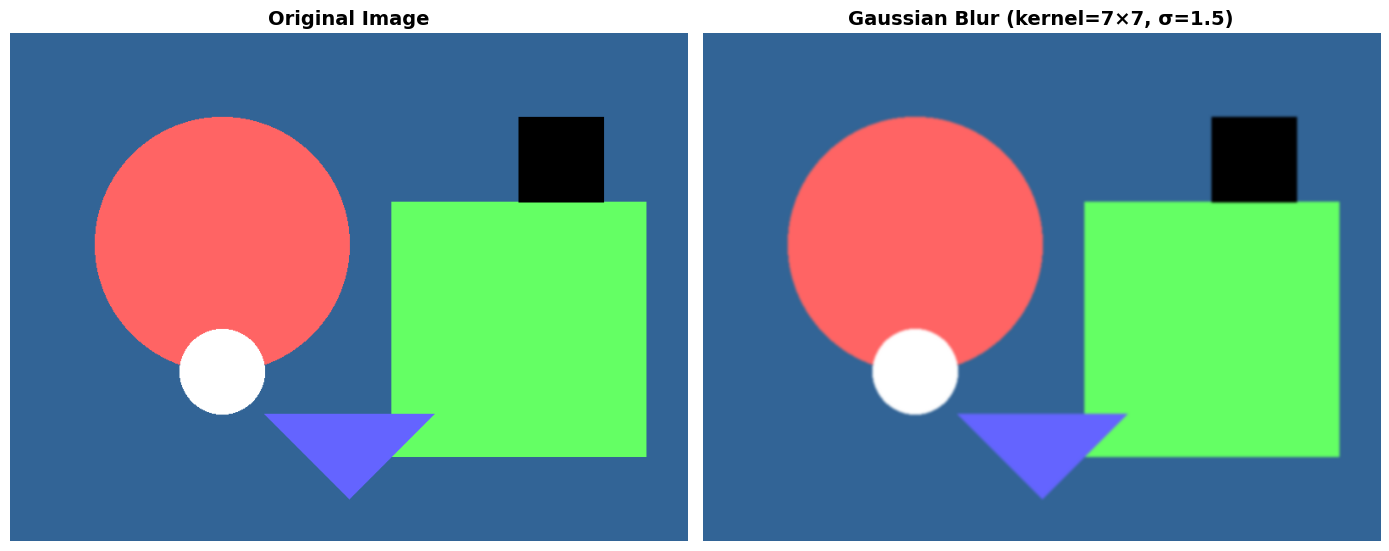

In [32]:
main()

# Timing Comparisons


GAUSSIAN BLUR: CPU vs CUDA (FAIR COMPARISON)
Kernel: 7×7, σ=1.5
Runs per size: 10

Initializing CUDA (one-time cost, not included in timing)...
Kernel: [[  18   56  108  135  108   56   18]
 [  56  169  329  411  329  169   56]
 [ 108  329  641  801  641  329  108]
 [ 135  411  801 1000  801  411  135]
 [ 108  329  641  801  641  329  108]
 [  56  169  329  411  329  169   56]
 [  18   56  108  135  108   56   18]]
Kernel Sum: 13644
CUDA initialized and kernel compiled (one-time cost)
CUDA ready!

400×300 (120,000 pixels)
----------------------------------------------------------------------
  Testing CPU (SciPy)... 1.43 ± 0.07 ms
  Testing CUDA... 0.11 ± 0.01 ms
  Speedup: 12.49x

800×600 (480,000 pixels)
----------------------------------------------------------------------
  Testing CPU (SciPy)... 5.84 ± 0.15 ms
  Testing CUDA... 0.28 ± 0.03 ms
  Speedup: 20.50x

1280×720 (HD) (921,600 pixels)
----------------------------------------------------------------------
  Testing CPU (Sci

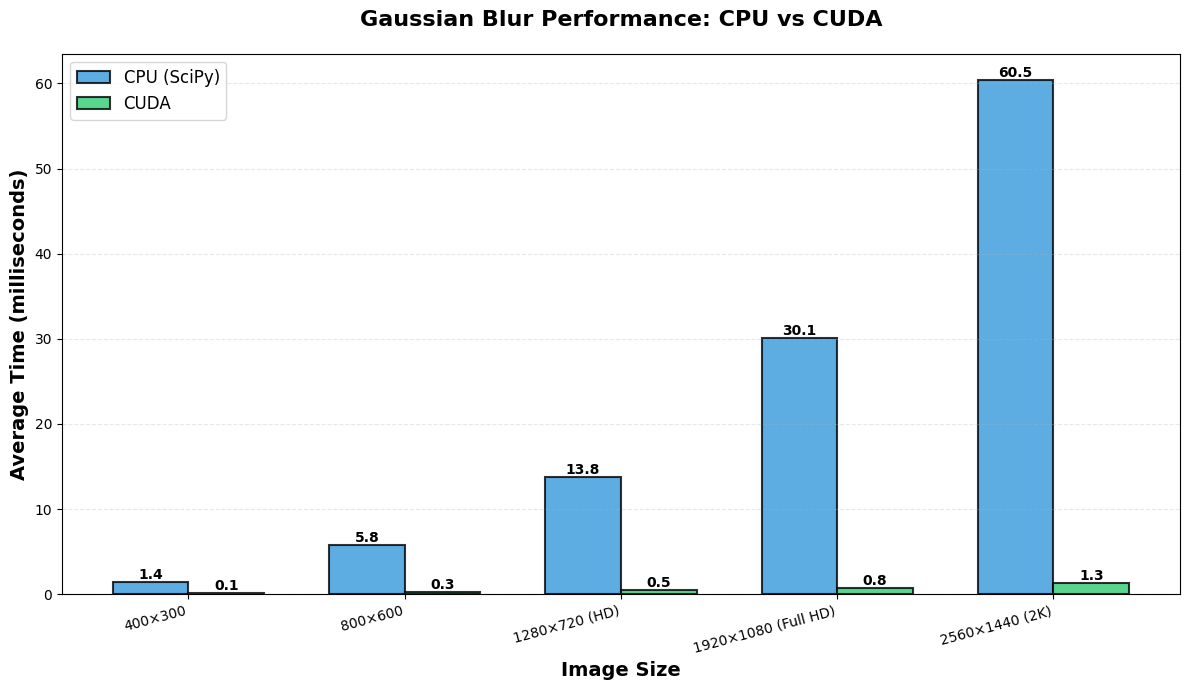

SUMMARY
Image Size                CPU (ms)     CUDA (ms)    Speedup   
----------------------------------------------------------------------
400×300                         1.43         0.11      12.49x
800×600                         5.84         0.28      20.50x
1280×720 (HD)                  13.80         0.49      28.15x
1920×1080 (Full HD)            30.08         0.78      38.32x
2560×1440 (2K)                 60.46         1.29      47.01x


In [33]:
import time
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from cuda.bindings import driver, nvrtc


# ============================================================
# CUDA BLUR WITH PERSISTENT STATE
# ============================================================

class CudaGaussianBlur:
    """
    CUDA Gaussian Blur with persistent state (compile once, use many times)
    """
    
    def __init__(self, kernel_size=7, sigma=1.5):
        """Initialize CUDA and compile kernel once"""
        self.kernel_size = kernel_size
        self.sigma = sigma
        
        # Initialize CUDA
        checkCudaErrors(driver.cuInit(0))
        self.device = checkCudaErrors(driver.cuDeviceGet(0))
        
        # Get compute capability
        major = checkCudaErrors(driver.cuDeviceGetAttribute(
            driver.CUdevice_attribute.CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MAJOR, 
            self.device))
        minor = checkCudaErrors(driver.cuDeviceGetAttribute(
            driver.CUdevice_attribute.CU_DEVICE_ATTRIBUTE_COMPUTE_CAPABILITY_MINOR, 
            self.device))
        
        # Compile kernel ONCE
        kernel_code = generate_gaussian_kernel_code(kernel_size, sigma)
        prog = checkCudaErrors(nvrtc.nvrtcCreateProgram(
            kernel_code.encode(), b"gaussian_blur.cu", 0, [], []))
        
        arch_arg = f'--gpu-architecture=compute_{major}{minor}'.encode()
        checkCudaErrors(nvrtc.nvrtcCompileProgram(prog, 1, [arch_arg]))
        
        ptx_size = checkCudaErrors(nvrtc.nvrtcGetPTXSize(prog))
        ptx = b" " * ptx_size
        checkCudaErrors(nvrtc.nvrtcGetPTX(prog, ptx))
        
        # Create context ONCE
        self.context = checkCudaErrors(driver.cuCtxCreate(0, self.device))
        
        # Load module ONCE
        ptx_data = np.char.array(ptx)
        self.module = checkCudaErrors(driver.cuModuleLoadData(ptx_data.ctypes.data))
        self.kernel = checkCudaErrors(driver.cuModuleGetFunction(
            self.module, b"gaussian_blur"))
        
        # Create stream ONCE
        self.stream = checkCudaErrors(driver.cuStreamCreate(0))
        
        print("CUDA initialized and kernel compiled (one-time cost)")
    
    def process(self, img_array):
        """
        Process image (only data transfer + kernel execution)
        This is what we time for fair comparison
        """
        # Handle dimensions
        if len(img_array.shape) == 2:
            img_array = img_array[:, :, np.newaxis]
            channels = 1
        else:
            channels = img_array.shape[2]
        
        height, width = img_array.shape[:2]
        buffer_size = width * height * channels
        
        # Allocate GPU memory
        d_input = checkCudaErrors(driver.cuMemAlloc(buffer_size))
        d_output = checkCudaErrors(driver.cuMemAlloc(buffer_size))
        
        # Transfer to GPU
        checkCudaErrors(driver.cuMemcpyHtoDAsync(
            d_input, img_array.ctypes.data, buffer_size, self.stream))
        
        # Configure launch
        BLOCK_SIZE_X = 16
        BLOCK_SIZE_Y = 16
        GRID_SIZE_X = (width + BLOCK_SIZE_X - 1) // BLOCK_SIZE_X
        GRID_SIZE_Y = (height + BLOCK_SIZE_Y - 1) // BLOCK_SIZE_Y
        
        # Prepare arguments
        args_data = [
            np.array([int(d_input)], dtype=np.intp),
            np.array([int(d_output)], dtype=np.intp),
            np.array([width], dtype=np.int32),
            np.array([height], dtype=np.int32),
            np.array([channels], dtype=np.int32)
        ]
        args = np.array([arg.ctypes.data for arg in args_data], dtype=np.intp)
        
        # Launch kernel
        checkCudaErrors(driver.cuLaunchKernel(
            self.kernel,
            GRID_SIZE_X, GRID_SIZE_Y, 1,
            BLOCK_SIZE_X, BLOCK_SIZE_Y, 1,
            0, self.stream, args.ctypes.data, 0))
        
        # Copy result back
        output_array = np.empty_like(img_array)
        checkCudaErrors(driver.cuMemcpyDtoHAsync(
            output_array.ctypes.data, d_output, buffer_size, self.stream))
        checkCudaErrors(driver.cuStreamSynchronize(self.stream))
        
        # Cleanup memory (not context/module/kernel)
        checkCudaErrors(driver.cuMemFree(d_input))
        checkCudaErrors(driver.cuMemFree(d_output))
        
        if channels == 1:
            output_array = output_array.squeeze()
        
        return output_array
    
    def cleanup(self):
        """Cleanup CUDA resources"""
        checkCudaErrors(driver.cuStreamDestroy(self.stream))
        checkCudaErrors(driver.cuModuleUnload(self.module))
        checkCudaErrors(driver.cuCtxDestroy(self.context))


# ============================================================
# CPU IMPLEMENTATION
# ============================================================

def gaussian_blur_cpu(img_array, sigma=1.5):
    """CPU implementation using SciPy"""
    if len(img_array.shape) == 2:
        return gaussian_filter(img_array, sigma=sigma, mode='nearest').astype(np.uint8)
    else:
        output = np.zeros_like(img_array)
        for c in range(img_array.shape[2]):
            output[:, :, c] = gaussian_filter(
                img_array[:, :, c], sigma=sigma, mode='nearest')
        return output.astype(np.uint8)


# ============================================================
# FAIR BENCHMARK
# ============================================================

def benchmark_comparison():
    """
    Compare CPU (SciPy) vs CUDA with FAIR timing
    """
    sizes = [
        (400, 300, "400×300"),
        (800, 600, "800×600"),
        (1280, 720, "1280×720 (HD)"),
        (1920, 1080, "1920×1080 (Full HD)"),
        (2560, 1440, "2560×1440 (2K)"),
    ]
    
    kernel_size = 7
    sigma = 1.5
    num_runs = 10
    
    cpu_times = []
    cuda_times = []
    size_labels = []
    
    print("\n" + "="*70)
    print("GAUSSIAN BLUR: CPU vs CUDA (FAIR COMPARISON)")
    print("="*70)
    print(f"Kernel: {kernel_size}×{kernel_size}, σ={sigma}")
    print(f"Runs per size: {num_runs}")
    print("="*70)
    
    # Initialize CUDA ONCE (outside timing)
    print("\nInitializing CUDA (one-time cost, not included in timing)...")
    cuda_blur = CudaGaussianBlur(kernel_size, sigma)
    print("CUDA ready!\n")
    
    for width, height, label in sizes:
        print(f"{label} ({width*height:,} pixels)")
        print("-" * 70)
        
        # Create test image
        img = Image.new('RGB', (width, height))
        draw = ImageDraw.Draw(img)
        draw.rectangle([0, 0, width, height], fill=(100, 150, 200))
        draw.ellipse([width//4, height//4, 3*width//4, 3*height//4], 
                     fill=(255, 100, 100))
        img_array = np.array(img, dtype=np.uint8)
        
        # Benchmark CPU
        print("  Testing CPU (SciPy)...", end=" ")
        cpu_run_times = []
        for _ in range(num_runs):
            start = time.perf_counter()
            _ = gaussian_blur_cpu(img_array, sigma)
            end = time.perf_counter()
            cpu_run_times.append((end - start) * 1000)
        
        cpu_avg = np.mean(cpu_run_times)
        cpu_std = np.std(cpu_run_times)
        print(f"{cpu_avg:.2f} ± {cpu_std:.2f} ms")
        
        # Benchmark CUDA (only timing the actual processing, not initialization)
        print("  Testing CUDA...", end=" ")
        
        # Warmup run (not timed)
        _ = cuda_blur.process(img_array)
        
        cuda_run_times = []
        for _ in range(num_runs):
            start = time.perf_counter()
            _ = cuda_blur.process(img_array)
            end = time.perf_counter()
            cuda_run_times.append((end - start) * 1000)
        
        cuda_avg = np.mean(cuda_run_times)
        cuda_std = np.std(cuda_run_times)
        speedup = cpu_avg / cuda_avg
        print(f"{cuda_avg:.2f} ± {cuda_std:.2f} ms")
        print(f"  Speedup: {speedup:.2f}x\n")
        
        cpu_times.append(cpu_avg)
        cuda_times.append(cuda_avg)
        size_labels.append(label)
    
    # Cleanup CUDA
    cuda_blur.cleanup()
    
    # Plot results
    plot_results(size_labels, cpu_times, cuda_times)
    
    # Print summary
    print_summary(size_labels, cpu_times, cuda_times)


def plot_results(labels, cpu_times, cuda_times):
    """Create comparison plot"""
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(labels))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, cpu_times, width, label='CPU (SciPy)',
                   color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, cuda_times, width, label='CUDA',
                   color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Image Size', fontsize=14, fontweight='bold')
    ax.set_ylabel('Average Time (milliseconds)', fontsize=14, fontweight='bold')
    ax.set_title('Gaussian Blur Performance: CPU vs CUDA', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=15, ha='right')
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    add_labels(bars1)
    add_labels(bars2)
    
    plt.tight_layout()
    plt.savefig('cuda_vs_cpu_benchmark.png', dpi=150, bbox_inches='tight')
    print("\nBenchmark plot saved: cuda_vs_cpu_benchmark.png")
    plt.show()


def print_summary(labels, cpu_times, cuda_times):
    """Print summary table"""
    print("="*70)
    print("SUMMARY")
    print("="*70)
    print(f"{'Image Size':<25} {'CPU (ms)':<12} {'CUDA (ms)':<12} {'Speedup':<10}")
    print("-" * 70)
    for label, cpu_t, cuda_t in zip(labels, cpu_times, cuda_times):
        speedup = cpu_t / cuda_t
        print(f"{label:<25} {cpu_t:>10.2f}   {cuda_t:>10.2f}   {speedup:>8.2f}x")


if __name__ == "__main__":
    benchmark_comparison()

# Gaussian Blur with CUDA Core

Nvidia provides a higher level interface called [CUDA core](https://nvidia.github.io/cuda-python/cuda-core/0.3.2/getting-started.html)



In [34]:
import numpy as np
import cupy as cp
from cuda.core.experimental import Device, Program, ProgramOptions, LaunchConfig, launch

In [ ]:
def generate_gaussian_kernel_code_cuda_core(kernel_size, sigma):
    """
    Generate CUDA kernel code with Gaussian weights
    
    Args:
        kernel_size: Size of kernel (e.g., 7 for 7×7)
        sigma: Standard deviation of Gaussian
        
    Returns:
        str: Complete CUDA C++ kernel code
    """
    # Calculate Gaussian kernel weights
    ax = np.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    
    # Scale to integers for better precision
    scale_factor = 1000
    kernel_int = np.round(kernel * scale_factor).astype(int)
    kernel_sum = kernel_int.sum()
    
    # Generate C++ array string
    kernel_str = "{\n"
    for row in kernel_int:
        kernel_str += "        {" + ", ".join(map(str, row)) + "},\n"
    kernel_str += "    }"
    
    offset = kernel_size // 2
    
    # Generate CUDA kernel using template
    code = f"""
template<typename T>
__global__ void gaussian_blur(const T* input, 
                              T* output,
                              int width, int height, int channels)
{{
    // Calculate 2D pixel position
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    
    if (x >= width || y >= height) return;
    
    // {kernel_size}x{kernel_size} Gaussian kernel (σ={sigma})
    const float kernel[{kernel_size}][{kernel_size}] = {kernel_str};
    const float kernel_sum = {kernel_sum}.0f;
    
    // Process each channel (grayscale=1, RGB=3, RGBA=4)
    for (int c = 0; c < channels; c++) {{
        float sum = 0.0f;
        
        // Apply convolution: weighted sum of neighbors
        for (int ky = 0; ky < {kernel_size}; ky++) {{
            for (int kx = 0; kx < {kernel_size}; kx++) {{
                // Calculate neighbor position
                int nx = x + kx - {offset};
                int ny = y + ky - {offset};
                
                // Clamp to image edges
                nx = max(0, min(nx, width - 1));
                ny = max(0, min(ny, height - 1));
                
                // Accumulate weighted pixel value
                int idx = (ny * width + nx) * channels + c;
                sum += input[idx] * kernel[ky][kx];
            }}
        }}
        
        // Write normalized result
        int out_idx = (y * width + x) * channels + c;
        output[out_idx] = (T)(sum / kernel_sum);
    }}
}}
"""
    return code

In [36]:
def gaussian_blur_cuda_core(img_array, kernel_size=7, sigma=1.5):
    """
    Apply Gaussian blur to image using cuda.core (high-level Pythonic API)
    
    Args:
        img_array: NumPy array of image (H, W) or (H, W, C)
        kernel_size: Size of Gaussian kernel (must be odd)
        sigma: Blur strength (higher = more blur)
        
    Returns:
        Blurred image as NumPy array
    """
    
    # ============================================================
    # IMAGE PREPROCESSING
    # ============================================================
    # Handle image dimensions - ensure 3D array (H, W, C)
    if len(img_array.shape) == 2:
        # Grayscale image - add channel dimension
        # Shape (H, W) becomes (H, W, 1)
        img_array = img_array[:, :, np.newaxis]
        channels = 1
    else:
        # Color image - extract number of channels (typically 3 for RGB, 4 for RGBA)
        channels = img_array.shape[2]
    
    # Extract image dimensions from shape tuple
    height, width = img_array.shape[:2]
    
    print(f"\n{'='*60}")
    print(f"Gaussian Blur Settings (cuda.core)")
    print(f"{'='*60}")
    print(f"  Image size: {width} x {height} pixels")
    print(f"  Channels: {channels}")
    print(f"  Kernel: {kernel_size}x{kernel_size}, σ={sigma}")
    
    # ============================================================
    # Step 1: Initialize Device and Stream
    # ============================================================
    # Reference: https://nvidia.github.io/cuda-python/cuda-core/latest/generated/cuda.core.experimental.Device.html
    print(f"\n{'='*60}")
    print("Step 1: Initialize cuda.core Device")
    print(f"{'='*60}")
    
    # Device() - Create or get Device object for GPU
    # Device is a singleton - calling Device() multiple times returns the same instance
    # This ensures interoperability across different libraries in the same process
    # Device() with no arguments gets the currently active device (usually GPU 0)
    # Alternative: Device(0) explicitly specifies device 0, Device(1) for GPU 1, etc.
    # Reference: https://nvidia.github.io/cuda-python/cuda-core/latest/generated/cuda.core.experimental.Device.html
    dev = Device()
    
    # set_current() - Initialize CUDA and set this device as current
    # This method:
    #   1. Initializes the CUDA driver (like cuInit in cuda.bindings)
    #   2. Creates/gets the primary context for this device
    #   3. Makes this context current for the calling thread
    # All subsequent CUDA operations will use this device
    # Unlike cuda.bindings, you don't manually manage contexts
    # Returns: None (or previous context if one was set)
    dev.set_current()
    
    # Get device information for display
    # These properties are accessed as attributes (Pythonic!)
    # dev.name - Device name string (e.g., "NVIDIA GeForce RTX 3080")
    # dev.compute_capability - Tuple of (major, minor) version
    # Example: (7, 5) for compute capability 7.5 (Turing architecture)
    print(f"  Device: {dev.name}")
    print(f"  Compute Capability: {'.'.join(map(str, dev.compute_capability))}")
    
    # create_stream() - Create a new CUDA stream for async operations
    # Stream: Queue of GPU operations that execute in order
    # Multiple streams allow concurrent kernel execution and data transfers
    # Unlike cuda.bindings (cuStreamCreate), this returns a managed Stream object
    # The stream is automatically cleaned up when the object is garbage collected
    # Alternative: dev.default_stream to use the default stream
    # Reference: https://nvidia.github.io/cuda-python/cuda-core/latest/generated/cuda.core.experimental._stream.Stream.html
    stream = dev.create_stream()
    
    print(f"  Device initialized and stream created")
    
    # ============================================================
    # Step 2: Compile CUDA Kernel
    # ============================================================
    # Reference: https://nvidia.github.io/cuda-python/cuda-core/latest/generated/cuda.core.experimental.Program.html
    print(f"\n{'='*60}")
    print("Step 2: Compile CUDA Kernel")
    print(f"{'='*60}")
    
    # Generate CUDA C++ kernel source code as string
    # This function creates a templated kernel with Gaussian weights embedded
    kernel_code = generate_gaussian_kernel_code_cuda_core(kernel_size, sigma)
    
    # Get architecture string for compilation
    # compute_capability is a tuple (major, minor), e.g., (7, 5)
    # We join them to create "75" for sm_75 architecture flag
    arch = "".join(f"{i}" for i in dev.compute_capability)
    
    # ProgramOptions - Specify compiler options for NVRTC
    # This is a dataclass that holds compilation settings
    # Parameters:
    #   std: C++ standard to use (e.g., "c++11", "c++14", "c++17", "c++20")
    #   arch: Target GPU architecture (e.g., "sm_75" for compute capability 7.5)
    #        Format: "sm_XY" where X=major, Y=minor
    #   Other options can include: optimize, debug, include_paths, etc.
    # Reference: https://nvidia.github.io/cuda-python/cuda-core/latest/generated/cuda.core.experimental.ProgramOptions.html
    program_options = ProgramOptions(
        std="c++17",           # Use C++17 standard (for modern C++ features)
        arch=f"sm_{arch}"      # Target specific GPU architecture
    )
    
    # Program() - Create a program object from source code
    # This represents a compilation unit (similar to nvrtcCreateProgram in cuda.bindings)
    # Parameters:
    #   code: Source code as string (CUDA C++ kernel code)
    #   code_type: Type of source code
    #       - "c++": CUDA C++ source (most common)
    #       - "ptx": PTX assembly
    #       - "cubin": Binary CUBIN
    #   options: ProgramOptions object with compiler settings
    # The Program object manages the NVRTC program lifecycle
    # No compilation happens yet - that's done by compile()
    # Reference: https://nvidia.github.io/cuda-python/cuda-core/latest/generated/cuda.core.experimental.Program.html
    prog = Program(
        kernel_code,           # CUDA C++ source code string
        code_type="c++",       # Specify source is C++ (not PTX/CUBIN)
        options=program_options  # Compiler options
    )
    
    # compile() - Compile the program to binary format
    # This performs the actual compilation using NVRTC
    # Parameters:
    #   target_type: Output format
    #       - "cubin": Compile to CUBIN (binary, GPU-specific, faster to load)
    #       - "ptx": Compile to PTX (assembly, portable across GPUs)
    #       - "ltoir": LTO-IR for link-time optimization
    #   name_expressions: Tuple of kernel/function names to compile
    #       - For templates, specify instantiation: "kernel<float>"
    #       - Can compile multiple: ("kernel<float>", "kernel<int>")
    #       - Only specified templates are compiled (saves time/space)
    # Returns: ObjectCode object containing the compiled binary
    # The ObjectCode can be used to extract kernels
    # Reference: https://nvidia.github.io/cuda-python/cuda-core/latest/generated/cuda.core.experimental.Program.html#cuda.core.experimental.Program.compile
    module = prog.compile(
        "cubin",  # Compile to CUBIN (binary format, faster than PTX)
        name_expressions=("gaussian_blur<unsigned char>",)  # Template instantiation
    )
    
    # get_kernel() - Extract a specific kernel from compiled code
    # Parameters:
    #   name: Kernel function name (must match what was compiled)
    #         For templates, use full instantiated name: "kernel<type>"
    # Returns: Kernel object that can be launched
    # Unlike cuda.bindings (cuModuleGetFunction), no need for bytes encoding
    # The Kernel object is a managed wrapper around CUfunction
    # Reference: https://nvidia.github.io/cuda-python/cuda-core/latest/generated/cuda.core.experimental.Kernel.html
    kernel = module.get_kernel("gaussian_blur<unsigned char>")
    
    print(f"  Kernel compiled successfully")
    
    # ============================================================
    # Step 3: Prepare Data (GPU Memory Management)
    # ============================================================
    # cuda.core integrates seamlessly with CuPy for memory management
    # CuPy handles GPU memory allocation automatically
    print(f"\n{'='*60}")
    print("Step 3: Prepare GPU Memory")
    print(f"{'='*60}")
    
    # cp.asarray() - Convert NumPy array to CuPy array (moves to GPU)
    # This automatically:
    #   1. Allocates GPU memory (like cuMemAlloc in cuda.bindings)
    #   2. Copies data from CPU to GPU (like cuMemcpyHtoD)
    #   3. Returns a GPU array that behaves like NumPy
    # Parameters:
    #   array: NumPy array to convert
    #   dtype: Data type (cp.uint8 = unsigned char)
    # The data transfer happens synchronously by default
    # CuPy manages the memory lifetime - freed when array is garbage collected
    d_input = cp.asarray(img_array, dtype=cp.uint8)
    
    # cp.empty_like() - Allocate uninitialized GPU array with same shape/type
    # This allocates GPU memory without copying or initializing
    # Similar to cuMemAlloc in cuda.bindings
    # The array will be filled by the kernel
    d_output = cp.empty_like(d_input)
    
    print(f"  Input copied to GPU: {d_input.nbytes:,} bytes")
    print(f"  Output allocated on GPU: {d_output.nbytes:,} bytes")
    
    # ============================================================
    # Step 4: Configure and Launch Kernel
    # ============================================================
    # Reference: https://nvidia.github.io/cuda-python/cuda-core/latest/generated/cuda.core.experimental.launch.html
    print(f"\n{'='*60}")
    print("Step 4: Launch Kernel")
    print(f"{'='*60}")
    
    # Configure 2D grid of thread blocks for parallel image processing
    # Each thread processes exactly one pixel
    
    # Block dimensions: threads per block in each dimension
    # 16×16 = 256 threads per block (common for 2D image processing)
    BLOCK_SIZE_X = 16
    BLOCK_SIZE_Y = 16
    
    # Grid dimensions: number of blocks needed to cover entire image
    # Formula: ceil(dimension / block_size)
    # This ensures enough threads even if image size isn't divisible by block size
    GRID_SIZE_X = (width + BLOCK_SIZE_X - 1) // BLOCK_SIZE_X
    GRID_SIZE_Y = (height + BLOCK_SIZE_Y - 1) // BLOCK_SIZE_Y
    
    print(f"  Grid:  {GRID_SIZE_X} × {GRID_SIZE_Y} blocks")
    print(f"  Block: {BLOCK_SIZE_X} × {BLOCK_SIZE_Y} threads")
    print(f"  Total: {GRID_SIZE_X * GRID_SIZE_Y * BLOCK_SIZE_X * BLOCK_SIZE_Y:,} threads")
    
    # LaunchConfig - Configure kernel launch parameters (Pythonic!)
    # This replaces the complex grid/block parameter passing in cuda.bindings
    # Parameters:
    #   grid: Grid dimensions as tuple or int
    #       - Tuple: (grid_x, grid_y, grid_z) for 2D/3D grids
    #       - Int: grid_x (for 1D grid)
    #   block: Block dimensions as tuple or int
    #       - Tuple: (block_x, block_y, block_z) for 2D/3D blocks
    #       - Int: block_x (for 1D block)
    #   shared_mem: Dynamic shared memory per block in bytes (default: 0)
    #   stream: Stream to execute in (default: None = default stream)
    # Much cleaner than cuda.bindings' 11-parameter cuLaunchKernel!
    # Reference: https://nvidia.github.io/cuda-python/cuda-core/latest/generated/cuda.core.experimental.LaunchConfig.html
    config = LaunchConfig(
        grid=(GRID_SIZE_X, GRID_SIZE_Y),   # 2D grid dimensions
        block=(BLOCK_SIZE_X, BLOCK_SIZE_Y)  # 2D block dimensions
    )
    
    # launch() - Launch CUDA kernel (the Pythonic way!)
    # This is the high-level kernel launch function
    # Parameters:
    #   stream: Stream to execute kernel in
    #   config: LaunchConfig object with grid/block configuration
    #   kernel: Kernel object to execute
    #   *args: Kernel arguments (variable length)
    # 
    # Kernel argument passing:
    #   - For GPU pointers: Use .data.ptr from CuPy arrays
    #       d_input.data.ptr gets the GPU memory address
    #   - For scalars: Pass Python int/float directly
    #       cuda.core automatically converts to correct C type
    #   - For CuPy types: Use cp.int32(), cp.uint64(), etc. for explicit types
    # 
    # Type mapping (automatic):
    #   Python int → C int (usually int32)
    #   Python float → C double
    #   cp.int32(x) → C int32_t
    #   cp.uint64(x) → C uint64_t
    #   cp.float32(x) → C float
    # 
    # No manual argument preparation needed!
    # Compare to cuda.bindings:
    #   - No need to wrap args in NumPy arrays
    #   - No need to create args array with ctypes.data
    #   - No need to manually convert pointers to integers
    # 
    # The kernel signature in CUDA C++:
    #   __global__ void gaussian_blur(
    #       const unsigned char* input,   // d_input.data.ptr
    #       unsigned char* output,        // d_output.data.ptr  
    #       int width,                    // width (Python int → C int)
    #       int height,                   // height (Python int → C int)
    #       int channels)                 // channels (Python int → C int)
    # 
    # Returns: None
    # Kernel launch is asynchronous - returns immediately
    # Reference: https://nvidia.github.io/cuda-python/cuda-core/latest/generated/cuda.core.experimental.launch.html
    launch(
        stream,              # Stream: Execute kernel in this stream
        config,              # Config: Grid and block configuration
        kernel,              # Kernel: Compiled kernel to execute
        d_input.data.ptr,    # Arg 1: Input GPU pointer (unsigned char*)
        d_output.data.ptr,   # Arg 2: Output GPU pointer (unsigned char*)
        width,               # Arg 3: Image width (int)
        height,              # Arg 4: Image height (int)
        channels             # Arg 5: Number of channels (int)
    )
    
    print(f"  Kernel launched")
    
    # ============================================================
    # Step 5: Synchronize and Retrieve Results
    # ============================================================
    print(f"\n{'='*60}")
    print("Step 5: Synchronize and Get Results")
    print(f"{'='*60}")
    
    # sync() - Synchronize stream (wait for all operations to complete)
    # This blocks the CPU thread until all operations in the stream finish
    # Operations include:
    #   - Kernel launches
    #   - Memory copies
    #   - Any other async operations
    # Similar to cuStreamSynchronize in cuda.bindings
    # After sync(), d_output contains the blurred image on GPU
    # Reference: https://nvidia.github.io/cuda-python/cuda-core/latest/generated/cuda.core.experimental._stream.Stream.html#cuda.core.experimental._stream.Stream.sync
    stream.sync()
    
    print(f"  Stream synchronized")
    
    # cp.asnumpy() - Convert CuPy array back to NumPy (copy GPU→CPU)
    # This automatically:
    #   1. Copies data from GPU to CPU (like cuMemcpyDtoH)
    #   2. Returns a NumPy array
    # The copy is synchronous - waits for GPU to finish
    # CuPy GPU memory remains allocated until d_output is garbage collected
    output_array = cp.asnumpy(d_output)
    
    print(f"  Result copied to CPU: {output_array.nbytes:,} bytes")
    
    # ============================================================
    # AUTOMATIC CLEANUP
    # ============================================================
    # Unlike cuda.bindings, NO manual cleanup needed!
    # cuda.core uses RAII (Resource Acquisition Is Initialization):
    #   - CuPy arrays: Memory freed when garbage collected
    #   - Stream: Destroyed when stream object goes out of scope
    #   - Kernel/Module: Cleaned up automatically
    #   - Context: Managed by Device singleton
    # 
    # Python's garbage collector handles everything!
    # No need for:
    #   - cuMemFree()
    #   - cuStreamDestroy()
    #   - cuModuleUnload()
    #   - cuCtxDestroy()
    
    # ============================================================
    # POST-PROCESSING
    # ============================================================
    
    # Remove channel dimension if original image was grayscale
    # squeeze() removes dimensions of size 1
    # Example: Shape (600, 800, 1) becomes (600, 800)
    if channels == 1:
        output_array = output_array.squeeze()
    
    print(f"\n{'='*60}")
    print("Gaussian Blur Complete!")
    print(f"{'='*60}")
    
    # Return blurred image as NumPy array
    return output_array


CUDA Gaussian Blur Demo
Using cuda.bindings only

Creating test image...
Test image created

Gaussian Blur Settings (cuda.core)
  Image size: 800 x 600 pixels
  Channels: 3
  Kernel: 7x7, σ=1.5

Step 1: Initialize cuda.core Device
  Device: NVIDIA GeForce RTX 5090
  Compute Capability: 12.0
  Device initialized and stream created

Step 2: Compile CUDA Kernel
  Kernel compiled successfully

Step 3: Prepare GPU Memory
  Input copied to GPU: 1,440,000 bytes
  Output allocated on GPU: 1,440,000 bytes

Step 4: Launch Kernel
  Grid:  50 × 38 blocks
  Block: 16 × 16 threads
  Total: 486,400 threads
  Kernel launched

Step 5: Synchronize and Get Results
  Stream synchronized
  Result copied to CPU: 1,440,000 bytes

Gaussian Blur Complete!


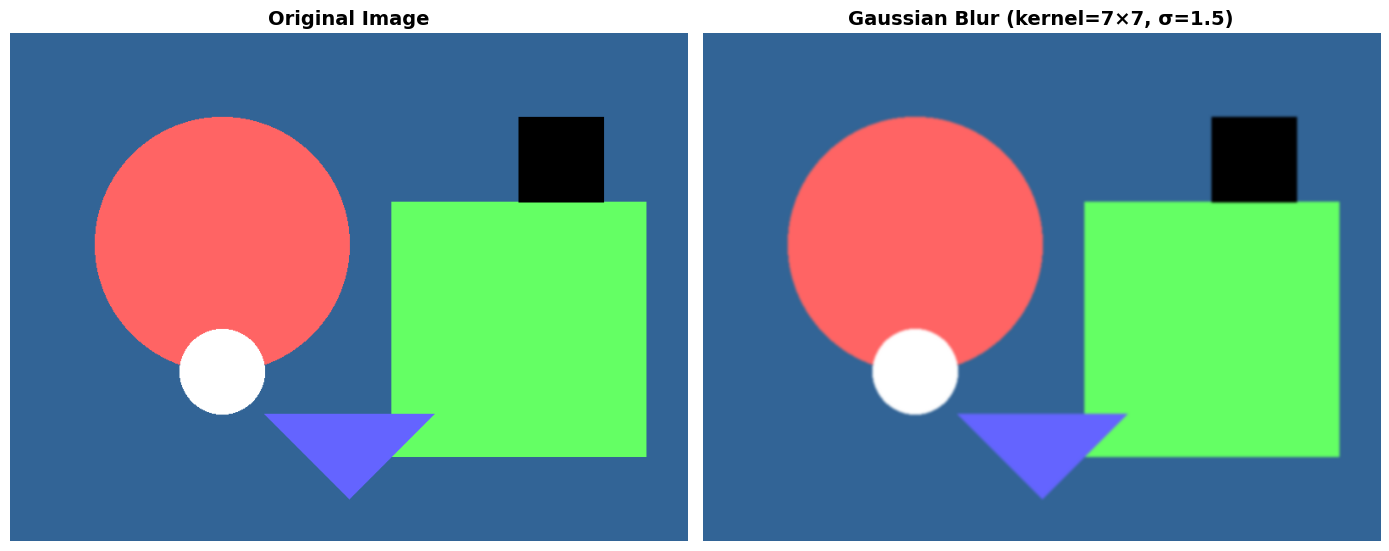

In [37]:
print("\n" + "="*60)
print("CUDA Gaussian Blur Demo")
print("Using cuda.bindings only")
print("="*60)

# Create test image
print("\nCreating test image...")
img = create_test_image()
print("Test image created")

# Convert to numpy array
img_array = np.array(img, dtype=np.uint8)

# Apply Gaussian blur
kernel_size = 7
sigma = 1.5

blurred_array = gaussian_blur_cuda_core(img_array, kernel_size, sigma)
    
# Display results
display_results(img_array, blurred_array, kernel_size, sigma)